# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
import requests
import joblib

import math

#Model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


#Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Plots
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
#Fix the random seed
np.random.seed(8)

# Load in Data

In [3]:
# Set the file path
path_name = "../input/392-crypto-currency-pairs-at-minute-resolution/solusd.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(path_name)

# Convert the 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], unit='ms')

# Remove duplicate rows based on the 'time' column
df = df.drop_duplicates(subset='time')

# Set the 'time' column as the index
df = df.set_index('time')

# Resample the data to a 1-minute interval and forward fill missing values
df = df.resample('1T').pad()

#   **Observe the dataset**



                        open    close     high      low      volume  \
time                                                                  
2021-11-18 10:02:00  209.620  210.270  210.340  209.620   57.599735   
2022-03-20 22:38:00   88.726   88.789   88.790   88.726    5.500000   
2021-07-17 07:16:00   26.544   26.544   26.544   26.544  384.443100   
2022-06-17 03:47:00   30.233   30.233   30.233   30.233    1.330000   
2021-04-22 10:05:00   37.175   37.175   37.175   37.175    1.614672   

                     Unnamed: 0  
time                             
2021-11-18 10:02:00         NaN  
2022-03-20 22:38:00         NaN  
2021-07-17 07:16:00         NaN  
2022-06-17 03:47:00         NaN  
2021-04-22 10:05:00         NaN  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1169183 entries, 2021-02-25 09:40:00 to 2023-05-18 08:02:00
Freq: T
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1169183 

<AxesSubplot:ylabel='time'>

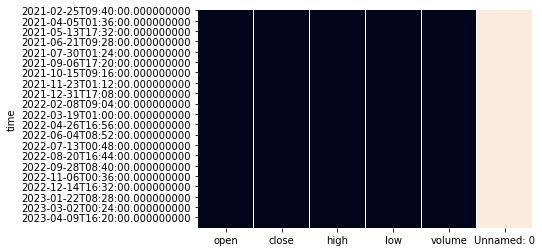

In [4]:
#Get a sample of the data
print(df.sample(5))

# Get a summary of the dataset
print(df.info())

# Check for null values
null_values = df.isnull()

# Count null values in each column
null_counts = null_values.sum()

# Print the count of null values
print(null_counts)

# Visualize null values using a heatmap
sns.heatmap(null_values, cbar=False)

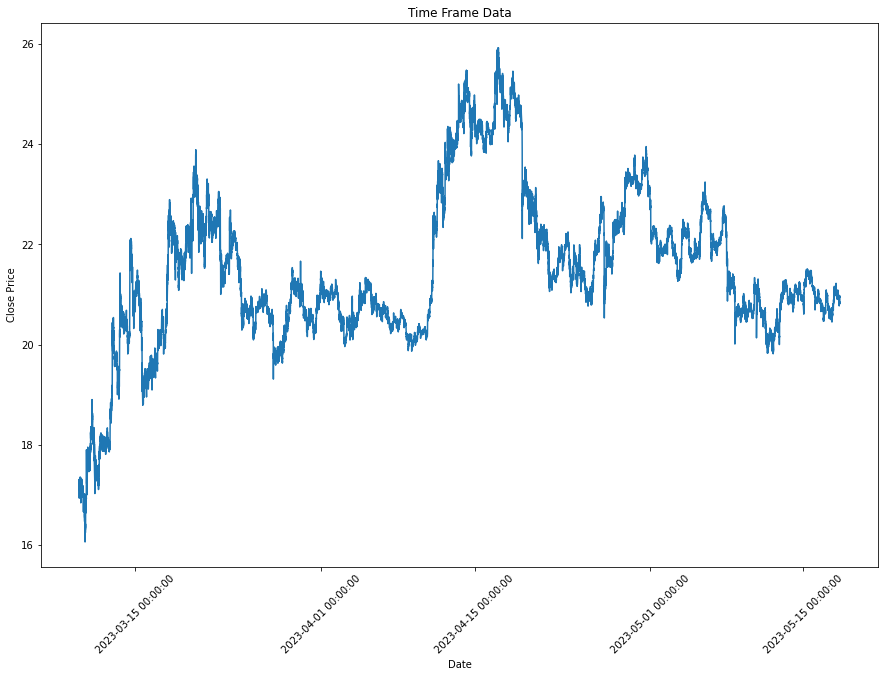

In [5]:
# Set the figure size
plt.figure(figsize=(15, 10))
# Plot the data
plt.plot(df.index[-100000:], df.close[-100000:])

# Format the x-axis tick labels as dates
date_format = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

# Rotate the x-axis tick labels for better visibility
plt.xticks(rotation=45)

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Time Frame Data')

# Display the plot
plt.show()


## Prepare Dataset

In [6]:
def create_dataset(dataset, look_back=5):
    dataX = dataset[:-look_back]  # Input sequences
    dataY = dataset[look_back:]  # Output values
    return np.array(dataX), np.array(dataY)

In [7]:
dataset = df['close'][-100000:].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)
dataset

array([[17.293],
       [17.28 ],
       [17.265],
       ...,
       [20.946],
       [20.968],
       [20.961]], dtype=float32)

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
from sklearn.model_selection import train_test_split

# Split into train and test sets
train, test = train_test_split(dataset, test_size=0.33, shuffle=False)

In [9]:
look_back = 6
#Create the dataset
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)
# Split the data into training and validation sets
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
val_X = np.reshape(val_X, (val_X.shape[0], val_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

## Training

In [10]:
# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create the model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(15, 1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model with early stopping
model.fit(train_X, train_Y, epochs=15, batch_size=12, verbose=0, validation_data=(val_X, val_Y), callbacks=[early_stopping])


## Prediction

In [11]:
#Predict the output
trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)


In [12]:
#Rescale the predicted values
trainPredict = scaler.inverse_transform(trainPredict)
train_Y = scaler.inverse_transform(train_Y)
testPredict = scaler.inverse_transform(testPredict)
test_Y = scaler.inverse_transform(test_Y)

# Evaluate the model

In [13]:


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error( train_Y[:,0],trainPredict[:,0]))
print('Train Score: %.2f RMSE' % trainScore)
testScore = math.sqrt(mean_squared_error(test_Y[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.08 RMSE
Test Score: 0.06 RMSE


In [14]:

mse = mean_squared_error(test_Y, testPredict)
mae = mean_absolute_error(test_Y, testPredict)
r2 = r2_score(test_Y, testPredict)

print("Mean Squared Error (MSE): %.2f" % mse)
print("Mean Absolute Error (MAE): %.2f" % mae)
print("R-squared (R^2): %.2f" % r2)

Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.05
R-squared (R^2): 1.00


In [15]:
# Make predictions on the validation data
val_predictions = model.predict(val_X)

# Calculate evaluation metrics
val_mse = mean_squared_error(val_Y, val_predictions)
val_mae = mean_absolute_error(val_Y, val_predictions)
val_r2 = r2_score(val_Y, val_predictions)

print("Validation Results:")
print("Mean Squared Error (MSE):", val_mse)
print("Mean Absolute Error (MAE):", val_mae)
print("R-squared (R^2):", val_r2)


Validation Results:
Mean Squared Error (MSE): 5.8888872e-05
Mean Absolute Error (MAE): 0.0053482507
R-squared (R^2): 0.9981868593918163


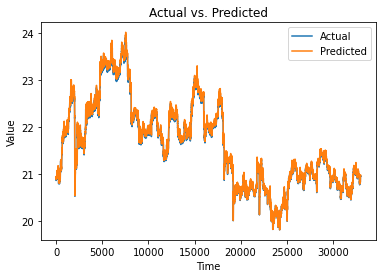

In [16]:
# Plotting the actual values
plt.plot(test_Y, label='Actual')

# Plotting the predicted values
plt.plot(testPredict, label='Predicted')

# Customize the plot
plt.title('Actual vs. Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()